## Analisando a relação entre Salário e Educação
Vamos testar uma hipótese:

 ### Será que estudar aumenta nossos salarios?

Vamos usar uma regressão de Salario ~ Estudo para nos ajudar a responder.

In [1]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
import numpy as np
from sqlalchemy import create_engine
import io
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

%matplotlib inline


In [2]:
#!pip install psycopg2
#!pip install sqlalchemy

In [2]:
df = pd.read_csv(r'./dados/5regressaosalarios.csv') #importando o arquivo

In [3]:
df.head() #verificando os dados

,Unnamed: 0,id,idade,sexo,anos_estudo,cor/raca,salario,estado_civil,regiao
0,0,1.100190e+10,53,homem,5.0,Parda,63600.000000,1.0,norte
1,1,1.100190e+10,49,mulher,8.0,Amarela,NaN,1.0,norte
2,2,1.100190e+10,22,mulher,11.0,Indigena,4352.400391,0.0,nordeste
3,3,1.100190e+10,55,homem,15.0,Amarela,96600.000000,1.0,norte
4,4,1.100190e+10,56,mulher,15.0,Amarela,157800.000000,1.0,norte


In [4]:
df.corr() #verificando a correlação e entre as variáveis

,Unnamed: 0,id,idade,anos_estudo,salario,estado_civil
Unnamed: 0,1.000000,0.970360,0.044996,0.017342,0.018171,0.035717
id,0.970360,1.000000,0.051951,0.035653,0.022322,0.029462
idade,0.044996,0.051951,1.000000,-0.223166,0.122228,0.209986
anos_estudo,0.017342,0.035653,-0.223166,1.000000,0.101445,-0.118830
salario,0.018171,0.022322,0.122228,0.101445,1.000000,0.031017
estado_civil,0.035717,0.029462,0.209986,-0.118830,0.031017,1.000000


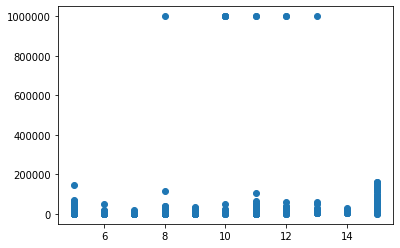

In [5]:
# imprimindo um gráfico scatter para tentar inferir alguma relação
sample = df.dropna().sample(1000, random_state=7)
plt.scatter(sample['anos_estudo'], sample['salario'])

Dificil inferir algo desse grafico, mas já vemos que tem alguns outliners que não fazem muito sentido, vamos filtra-los.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66470 entries, 0 to 66469
Data columns (total 9 columns):
Unnamed: 0      66470 non-null int64
id              66470 non-null float64
idade           66470 non-null int64
sexo            66470 non-null object
anos_estudo     66036 non-null float64
cor/raca        66228 non-null object
salario         47878 non-null float64
estado_civil    66470 non-null float64
regiao          66470 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 4.6+ MB


In [7]:
mascara_salario = df.salario<500000
sample = df[mascara_salario].dropna().sample(1000, random_state=7)
df['coluna'] = mascara_salario

df.head()

,Unnamed: 0,id,idade,sexo,anos_estudo,cor/raca,salario,estado_civil,regiao,coluna
0,0,1.100190e+10,53,homem,5.0,Parda,63600.000000,1.0,norte,True
1,1,1.100190e+10,49,mulher,8.0,Amarela,NaN,1.0,norte,False
2,2,1.100190e+10,22,mulher,11.0,Indigena,4352.400391,0.0,nordeste,True
3,3,1.100190e+10,55,homem,15.0,Amarela,96600.000000,1.0,norte,True
4,4,1.100190e+10,56,mulher,15.0,Amarela,157800.000000,1.0,norte,True


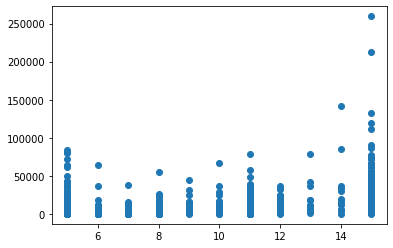

In [8]:
plt.scatter(sample['anos_estudo'], sample['salario'])

In [9]:
df['coluna'] = mascara_salario

In [10]:
sample[['anos_estudo','salario']].corr() #analisando a correlação

,anos_estudo,salario
anos_estudo,1.00000,0.32395
salario,0.32395,1.00000


Correlação de 0.3 responde nossa pergunta. Quanto mais estudo mais salario, além disso a taxa é de 30% de "transferência" entre estudo e salario. Está certo isso? Quais os problemas?

Vamos rodar uma regressão para ver as diferenças.

In [11]:
model = LinearRegression(fit_intercept=True)

model.fit(sample['anos_estudo'][:, np.newaxis], sample['salario'])

xfit = np.linspace(0, 14, 1000)
yhat = model.predict(xfit[:, np.newaxis])

print("Intercepto beta_0: ", model.intercept_)
print("Inclinação beta_1: ", model.coef_[0])

Intercepto beta_0:  -3296.2637767190245
Inclinação beta_1:  1707.8013864648758


In [12]:
print("R^2: ", model.score(sample['anos_estudo'][:, np.newaxis], sample['salario']))

R^2:  0.10494385916738314


Utilizando o método Scipy.Stats.Linregress

In [13]:
# método Scipy.Stats.Linregress
import scipy.stats
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(sample['anos_estudo'], sample['salario'])

In [14]:
print ('Inclinação:', slope)
print ('Intercepto:', intercept)
print ('R-quadrado:', r_value**2)

Inclinação: 1707.8013864648765
Intercepto: -3296.2637767190317
R-quadrado: 0.10494385916738319


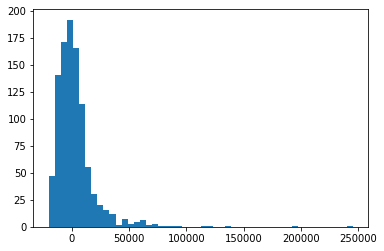

In [15]:
# plotando os erros, diferença entre a realidade e a normalidade, o melhor modelo é aquele que os 
# resultados estão próximos de zero
# o erro é y -yhat , o previsto e a realidade
y = sample['salario']
plt.hist(y - yhat,bins=50)

plt.show()

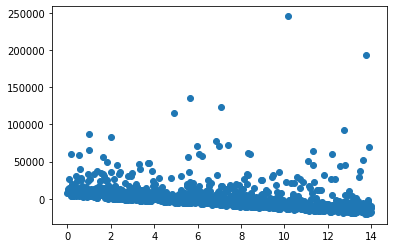

In [16]:
plt.scatter(xfit, y-yhat)

## Estudar a relação entre idade e salário

In [17]:
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")

In [18]:
list(df)

['Unnamed: 0',
 'id',
 'idade',
 'sexo',
 'anos_estudo',
 'cor/raca',
 'salario',
 'estado_civil',
 'regiao',
 'coluna']

In [19]:
function = '''salario ~ anos_estudo + np.exp(anos_estudo) + np.sqrt(anos_estudo)'''

%time model = smf.ols(function, df[df.salario<500000]).fit()

Wall time: 395 ms


In [45]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Ordinary least squares
=================================================================================
Model:                  OLS                  Adj. R-squared:         0.159       
Dependent Variable:     salario              AIC:                    1058692.4832
Date:                   2019-05-06 14:07     BIC:                    1058727.5288
No. Observations:       47165                Log-Likelihood:         -5.2934e+05 
Df Model:               3                    F-statistic:            2969.       
Df Residuals:           47161                Prob (F-statistic):     0.00        
R-squared:              0.159                Scale:                  3.2803e+08  
---------------------------------------------------------------------------------
                        Coef.     Std.Err.    t    P>|t|     [0.025      0.975]  
---------------------------------------------------------------------------------
Intercept             39930.5385 5129.0525  7.7852 0.0000  29877.5223  49983.5548
anos_estudo            5241.2495  675.2191  7.7623 0.0000   3917.8105   6564.6885
np.exp(anos_estudo)       0.0053    0.0002 23.2666 0.0000      0.0048      0.0057
np.sqrt(anos_estudo) -26119.4560 3775.3049 -6.9185 0.0000 -33519.1076 -18719.8045
---------------------------------------------------------------------------------
Omnibus:                 58616.733         Durbin-Watson:            1.784       
Prob(Omnibus):           0.000             Jarque-Bera (JB):         13361017.925
Skew:                    6.669             Prob(JB):                 0.000       
Kurtosis:                84.369            Condition No.:            79793661    
=================================================================================
* The condition number is large (8e+07). This might indicate             strong
multicollinearity or other numerical problems.
"""